#### To only test the model run only these and adjust the paths:

1.Imports and Dataset Class

2.Define the Dataset Class

3.Set Paths and Transformations

4.Create Dataset and DataLoader

5.Initialize the Model

6.Setup Device (no need to run optimizer)

9.Load the Pre-trained Model Weights

10.Load Image and Make Predictions

11.Example Usage



1. Imports and Dataset Class


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Define the Dataset Class


In [ ]:
class CardboardDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_files[idx])
        json_path = os.path.splitext(img_path)[0] + '.json'

        image = Image.open(img_path).convert("RGB")
        with open(json_path) as f:
            annotations = json.load(f)

        boxes = []
        for shape in annotations['shapes']:
            x_coords = [point[0] for point in shape['points']]
            y_coords = [point[1] for point in shape['points']]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transform:
            image = self.transform(image)

        return image, target


3. Set Paths and Transformations


In [ ]:
# Paths
data_detection_dir = '/content/drive/My Drive/Robotics/annotated'

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

4. Create Dataset and DataLoader


In [ ]:
# Datasets
dataset = CardboardDetectionDataset(root_dir=data_detection_dir, transform=transform)

# DataLoaders
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


5. Initialize the Model


In [ ]:
# Model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 113MB/s]


6. Setup Device and Optimizer


In [ ]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


7. Training Loop


In [ ]:
# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch} - Loss: {epoch_loss}')

8. Save the Model


In [ ]:
# Save model
torch.save(model.state_dict(), '/content/drive/My Drive/Robotics/faster_rcnn_model.pth')


9. Load the Model Weights


In [ ]:
# Load pre-trained model weights
model.load_state_dict(torch.load('/content/drive/My Drive/Robotics/faster_rcnn_model.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

10. Load Image and Make Predictions


In [ ]:
# Load image and make predictions
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

def visualize_predictions(image, predictions):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    boxes = predictions['boxes'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()

    count = 0
    for box, score in zip(boxes, scores):
        if score > 0.5:
            count += 1
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.title(f"Detected boxes: {count}")
    plt.show()

    return count

def get_actual_box_count(json_path):
    with open(json_path) as f:
        annotations = json.load(f)
    return len(annotations['shapes'])

11. Example Usage


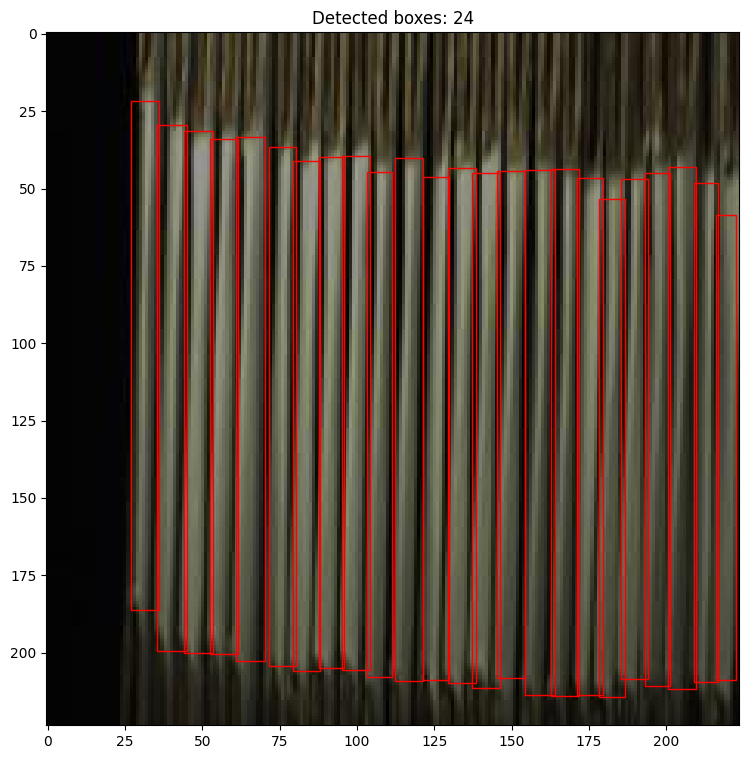

Detected boxes: 24
Actual boxes: 24


In [ ]:
# Example usage
image_path = '/content/drive/My Drive/Robotics/annotated/Statistics01_01_1970068.jpg'
json_path = '/content/drive/My Drive/Robotics/annotated/Statistics01_01_1970068.json'

image_tensor = load_image(image_path)
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
    detected_count = visualize_predictions(image_tensor[0], predictions[0])
    actual_count = get_actual_box_count(json_path)

print(f'Detected boxes: {detected_count}')
print(f'Actual boxes: {actual_count}')
